In [13]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer, auc, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import mlflow
from itertools import product
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import pipeline
from itertools import product
from scipy.optimize import fmin
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# For the final model, we will need one CSV we created :
# - data_final is the features normalized for every individual. This will be split in train/test set.
# We add again the sample weight for the model to priotirize the positive class when calculating the loss.

data_final = pd.read_csv('data_after_featuring.csv').drop(columns = ['Unnamed: 0'])
df_copy = data_final.copy()
X = df_copy.loc[:, (df_copy.columns != 'TARGET')&(df_copy.columns != 'SK_ID_CURR')]
y = df_copy['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y)

sample_weights = np.zeros(len(y_train))
sample_weights[y_train == 0] = (y_train.shape[0]/2)/y_train[y_train == 0].shape[0]
sample_weights[y_train == 1] = (y_train.shape[0]/2)/y_train[y_train == 1].shape[0]

In [74]:
def apply_threshold(predict, threshold):
    """
    Apply a threshold into a probability vector
    
    Parameters
    ----------
    -predict (array of shape (nb_individuals, 2)): the probability vector of shape  
    -threshold (float in range [0,1]): the value from where we set the prediction to class 1 
    
    Returns
    ----------
    -pred (array of shape (nb_individuals, 1)) : class 0 or 1 for each indivuals
    
    """
    pred = predict.copy()
    pred = pred[:, 1]
    matching = (pred >= threshold)
    pred[matching] = 1
    pred[~matching] = 0
    return pred


def bank_scoring(y_test, predict):
    """
    Calculate the bankscore from the real classes vs the predicted classes
    BE CAREFULL TO GIVE THEM IN THIS ORDER : bank_scoring(REAL, PREDICT)
    
    Parameters
    ----------
    -y_test (array of shape (nb_individuals, 1)): the True values of the class for each individuals
    -predict (array of shape (nb_individuals, 1)): the predicted values of the class for each individuals
    
    Returns
    ----------
    -loss_for_bank (int) : self made score to evaluate the models
    
    """
    confu = confusion_matrix(y_test, predict)
    FP = confu[0,1]
    FN = confu[1,0]
    loss_for_bank = 10 * FP + FN
    return loss_for_bank


banklosss = make_scorer(bank_scoring, greater_is_better=False)


In [103]:
# We create some new functions :


def find_best_threshold(fitted_model, X_test, y_test):
    """
    This function search for the best threshold to apply to the predict.proba on the fitted_model to maximise the bank score.
    
    Parameters
    ----------
    -fitted_model : a model fitted with the train part of the datas
    -X_test : the individuals that the model havent seen yet
    -y_test : the expected classes of each individuals.
    
    Returns
    ---------
    It will prints the scores (acc & bankloss) before threshold optimisation, 
    It will print the new scores after optimisation
    It will return the minimum threshold value.
    
    """
    
    predictions = fitted_model.predict_proba(X_test)
    
    def loss_with_threshold(threshold):
        predict_thresh = apply_threshold(predictions, threshold)
        loss_for_bank = bank_scoring(y_test, predict_thresh)
        return loss_for_bank
    
    before = apply_threshold(predictions, 0.5)
    print(f'before treshold optimisation, acc = {accuracy_score(y_test, before)} and bankscore = {bank_scoring(y_test, before)}')
    minimum = fmin(loss_with_threshold, 0.5)
    predict_thresh = apply_threshold(predictions, minimum[0])
    acc = accuracy_score(y_test, predict_thresh)
    print(f'For the best threshold {minimum[0]}, the accuracy score is {acc}')
    return minimum[0]

    
def plot_roc_curve(fitted_model, X_test, y_test):
    """
    This will just plot the roc_curve with AUC
    
    """
    predictions = fitted_model.predict_proba(X_test)
    preds = predictions[:,1]
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    plt.title(f'ROC curve, AUC = {round(roc_auc, 2)}')
    plt.plot(fpr, tpr)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def show_conclusion(model):
    """
    Conclusion of a gridsearch from the model:
    -Best threshold optimisation
    -ROC curve/AUC
    -Confusion matrix on Test, train, and all datas
        -> This is used to detect overfitting (if the model does 100% acc on xtrain but very low on Xtest)
    -the result of each split sorted by best model to worse one.
    """
    print(model.best_params_)
    find_best_threshold(model, X_test, y_test)
    plot_roc_curve(model, X_test, y_test)
    print('confusion_matrix on test set')
    display(confusion_matrix(y_test, model.predict(X_test)))
    print('confusion_matrix on train set')
    display(confusion_matrix(y_train, model.predict(X_train)))
    print('confusion_matrix on all data')
    display(confusion_matrix(data_final['TARGET'],model.predict(data_final.drop(columns = ['SK_ID_CURR', 'TARGET']))))
    display(pd.DataFrame(model.cv_results_).sort_values(by = 'rank_test_score'))

In [78]:
# I lack time, i need to run faster algorithm than the one we tested previous notebook. The winner from 
# Projet7_classifier_choice.ipynb was GradientBoosterClassifier. We use the time optimised version :
# HistGradientBoostingClassifier.

from sklearn.ensemble import HistGradientBoostingClassifier
param = {}
param['max_iter']= [100,200]
param['learning_rate'] = [0.1,0.5]
param['max_depth'] = [15]
param['max_leaf_nodes'] = [None, 15, 30]
param['min_samples_leaf'] = [20,40,60]

gcv2 = GridSearchCV(HistGradientBoostingClassifier(),
                   param,
                   scoring = banklosss,
                   refit = True,
                   cv = 5)
gcv2.fit(X_train, y_train, sample_weight = sample_weights)


GridSearchCV(cv=5, estimator=HistGradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1, 0.5], 'max_depth': [15],
                         'max_iter': [100, 200],
                         'max_leaf_nodes': [None, 15, 30],
                         'min_samples_leaf': [20, 40, 60]},
             scoring=make_scorer(bank_scoring, greater_is_better=False))

{'learning_rate': 0.5, 'max_depth': 15, 'max_iter': 100, 'max_leaf_nodes': None, 'min_samples_leaf': 20}
before treshold optimisation, acc = 0.8516851594104868 and bankscore = 70658
Optimization terminated successfully.
         Current function value: 6318.000000
         Iterations: 18
         Function evaluations: 42
For the best threshold 0.973437500000001, the accuracy score is 0.9178167722465757


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


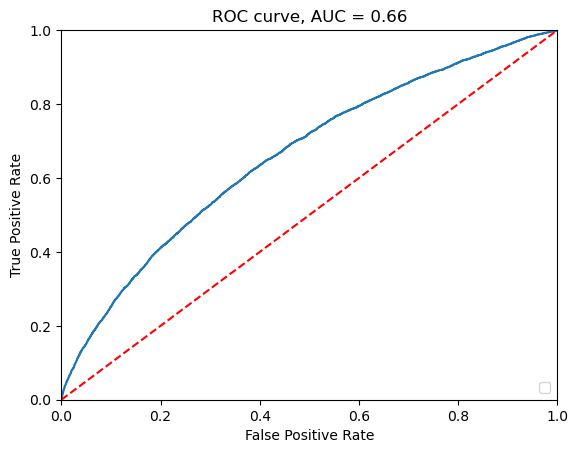

confusion_matrix on test set


array([[63969,  6584],
       [ 4818,  1506]], dtype=int64)

confusion_matrix on train set


array([[203589,   8540],
       [  1454,  17047]], dtype=int64)

confusion_matrix on all data


array([[267558,  15124],
       [  6272,  18553]], dtype=int64)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_max_iter,param_max_leaf_nodes,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
18,67.673215,0.857075,0.257446,0.009117,0.5,15,100,None,20,"{'learning_rate': 0.5, 'max_depth': 15, 'max_i...",-38360.0,-38248.0,-36618.0,-37103.0,-37330.0,-37531.8,672.083447,1
27,90.301421,3.368212,0.335120,0.031643,0.5,15,200,None,20,"{'learning_rate': 0.5, 'max_depth': 15, 'max_i...",-40484.0,-38904.0,-39194.0,-36616.0,-38955.0,-38830.6,1248.287403,2
0,131.966404,10.278534,0.367150,0.007502,0.1,15,100,None,20,"{'learning_rate': 0.1, 'max_depth': 15, 'max_i...",-41718.0,-44687.0,-41564.0,-45071.0,-42422.0,-43092.4,1492.114285,3
9,121.776274,6.105287,0.341727,0.023953,0.1,15,200,None,20,"{'learning_rate': 0.1, 'max_depth': 15, 'max_i...",-43582.0,-46919.0,-44151.0,-45714.0,-41769.0,-44427.0,1773.222941,4
19,52.012662,0.696893,0.259047,0.020053,0.5,15,100,None,40,"{'learning_rate': 0.5, 'max_depth': 15, 'max_i...",-47350.0,-45868.0,-47448.0,-46785.0,-47762.0,-47042.6,666.696813,5
28,65.123180,4.835591,0.307094,0.026166,0.5,15,200,None,40,"{'learning_rate': 0.5, 'max_depth': 15, 'max_i...",-49467.0,-47285.0,-46930.0,-46065.0,-48322.0,-47613.8,1175.616502,6
10,104.028728,4.152751,0.365950,0.018485,0.1,15,200,None,40,"{'learning_rate': 0.1, 'max_depth': 15, 'max_i...",-49108.0,-51383.0,-51117.0,-49346.0,-49558.0,-50102.4,951.492848,7
1,102.531899,2.745926,0.360544,0.020292,0.1,15,100,None,40,"{'learning_rate': 0.1, 'max_depth': 15, 'max_i...",-50167.0,-51766.0,-50351.0,-52652.0,-49043.0,-50795.8,1269.039858,8
20,45.109672,0.689365,0.252041,0.003767,0.5,15,100,None,60,"{'learning_rate': 0.5, 'max_depth': 15, 'max_i...",-53692.0,-52062.0,-54094.0,-56636.0,-54676.0,-54232.0,1482.962980,9
29,60.131214,4.507692,0.377961,0.078200,0.5,15,200,None,60,"{'learning_rate': 0.5, 'max_depth': 15, 'max_i...",-53181.0,-57131.0,-52883.0,-54419.0,-56249.0,-54772.6,1671.563292,10


In [79]:
# Analysis : we see on confusion matrix that the model does alot of False Positive mistakes. 
# We try to use a higer max_depth paramter on next gridsearch

show_conclusion(gcv2)

In [80]:
from sklearn.ensemble import HistGradientBoostingClassifier
param = {}
param['max_iter']= [100]
param['learning_rate'] = [0.5,0.75,1]
param['max_depth'] = [15,25,35]
param['max_leaf_nodes'] = [None]
param['min_samples_leaf'] = [10,20]

gcv2 = GridSearchCV(HistGradientBoostingClassifier(),
                   param,
                   scoring = banklosss,
                   refit = True,
                   cv = 5)
gcv2.fit(X_train, y_train, sample_weight = sample_weights)


GridSearchCV(cv=5, estimator=HistGradientBoostingClassifier(),
             param_grid={'learning_rate': [0.5, 0.75, 1],
                         'max_depth': [15, 25, 35], 'max_iter': [100],
                         'max_leaf_nodes': [None],
                         'min_samples_leaf': [10, 20]},
             scoring=make_scorer(bank_scoring, greater_is_better=False))

{'learning_rate': 0.75, 'max_depth': 35, 'max_iter': 100, 'max_leaf_nodes': None, 'min_samples_leaf': 10}
before treshold optimisation, acc = 0.9050301130377096 and bankscore = 20522
Optimization terminated successfully.
         Current function value: 6324.000000
         Iterations: 16
         Function evaluations: 42
For the best threshold 1.0750000000000013, the accuracy score is 0.9177387254965724


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


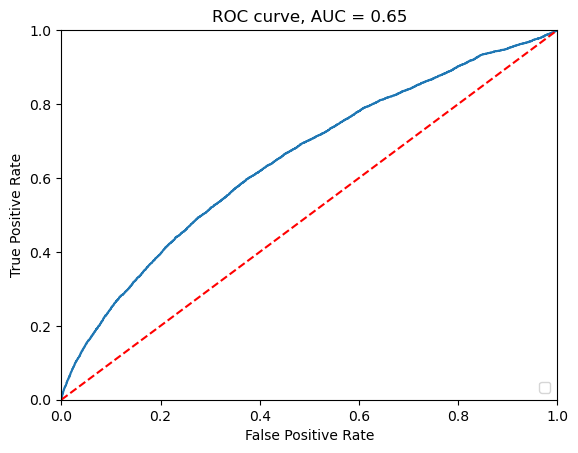

confusion_matrix on test set


array([[69084,  1469],
       [ 5832,   492]], dtype=int64)

confusion_matrix on train set


array([[211706,    423],
       [  1711,  16790]], dtype=int64)

confusion_matrix on all data


array([[280790,   1892],
       [  7543,  17282]], dtype=int64)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_max_iter,param_max_leaf_nodes,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
10,401.413677,19.382527,0.435415,0.024164,0.75,35,100,None,10,"{'learning_rate': 0.75, 'max_depth': 35, 'max_...",-12106.0,-12247.0,-11912.0,-12190.0,-11756.0,-12042.2,182.603833,1
16,281.241935,1.327801,0.325310,0.012518,1,35,100,None,10,"{'learning_rate': 1, 'max_depth': 35, 'max_ite...",-12447.0,-12322.0,-11740.0,-11555.0,-12477.0,-12108.2,384.216293,2
4,388.754389,93.909902,0.366350,0.017533,0.5,35,100,None,10,"{'learning_rate': 0.5, 'max_depth': 35, 'max_i...",-12418.0,-12470.0,-13230.0,-12341.0,-12318.0,-12555.4,341.638171,3
14,363.693661,85.440453,0.458038,0.111326,1,25,100,None,10,"{'learning_rate': 1, 'max_depth': 25, 'max_ite...",-13617.0,-13398.0,-12979.0,-12899.0,-13420.0,-13262.6,276.167051,4
8,256.306125,2.227370,0.316902,0.031777,0.75,25,100,None,10,"{'learning_rate': 0.75, 'max_depth': 25, 'max_...",-13683.0,-13319.0,-13041.0,-13528.0,-13902.0,-13494.6,296.369094,5
2,360.094024,12.852693,0.435416,0.069723,0.5,25,100,None,10,"{'learning_rate': 0.5, 'max_depth': 25, 'max_i...",-13743.0,-14232.0,-13874.0,-14493.0,-13864.0,-14041.2,278.857239,6
17,158.236287,3.310300,0.296083,0.014344,1,35,100,None,20,"{'learning_rate': 1, 'max_depth': 35, 'max_ite...",-17365.0,-16072.0,-16797.0,-16309.0,-16954.0,-16699.4,461.175281,7
11,257.789342,12.147761,0.447227,0.030158,0.75,35,100,None,20,"{'learning_rate': 0.75, 'max_depth': 35, 'max_...",-16424.0,-16962.0,-16321.0,-17008.0,-17324.0,-16807.8,378.046770,8
15,140.877913,1.761539,0.307494,0.014730,1,25,100,None,20,"{'learning_rate': 1, 'max_depth': 25, 'max_ite...",-17872.0,-17776.0,-17926.0,-17913.0,-18194.0,-17936.2,139.204023,9
5,189.225075,0.907058,0.318505,0.017582,0.5,35,100,None,20,"{'learning_rate': 0.5, 'max_depth': 35, 'max_i...",-18499.0,-18339.0,-17645.0,-17796.0,-18070.0,-18069.8,320.032123,10


In [81]:
# Analysis : Not really better. We see that the parameter Max_depth is actually having the most impact (3 best models
# have max_depth = 35). Also, the value of min_samples_leaf are better when lowered. 
show_conclusion(gcv2)

In [98]:
# Out of curiosity, i tried a model without max_depth to see the difference(By default, the value is None)
# I tried the best params found to optimise both time (lower max_iter) and score :

from sklearn.ensemble import HistGradientBoostingClassifier
test = HistGradientBoostingClassifier(max_iter = 100,
                                      learning_rate = 0.75,
                                      min_samples_leaf = 2,
                                      max_leaf_nodes = None,
                                      scoring = banklosss)

test.fit(X_train, y_train, sample_weight = sample_weights)


HistGradientBoostingClassifier(learning_rate=0.75, max_leaf_nodes=None,
                               min_samples_leaf=2,
                               scoring=make_scorer(bank_scoring, greater_is_better=False))

before treshold optimisation, acc = 0.9151501749547979 and bankscore = 9781
Optimization terminated successfully.
         Current function value: 6324.000000
         Iterations: 16
         Function evaluations: 42
For the best threshold 1.0750000000000013, the accuracy score is 0.9177387254965724


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


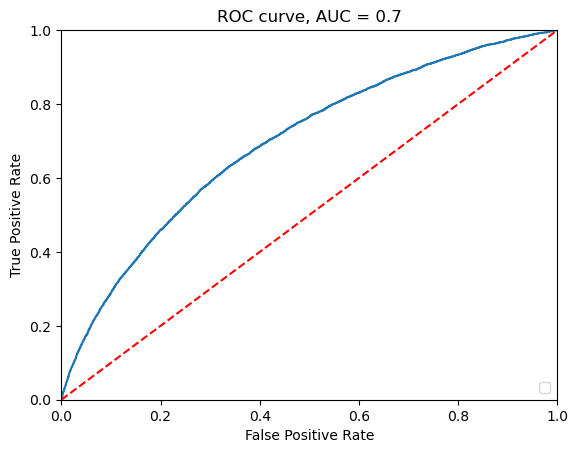

confusion_matrix on test set


array([[70191,   362],
       [ 6161,   163]], dtype=int64)

confusion_matrix on train set


array([[212039,     90],
       [  1798,  16703]], dtype=int64)

confusion_matrix on all data


array([[282230,    452],
       [  7959,  16866]], dtype=int64)

AttributeError: 'HistGradientBoostingClassifier' object has no attribute 'cv_results_'

In [99]:
# This ended up beeing the best so far. So i try a last gridsearch to optimise without max_depth param.
# The reason why this is the best score is cause it just refuses alot more of positive class (ending up False Negative)
# Since this error is 10 times less impactfull on our model, it end up scoring better.
show_conclusion(test)

In [102]:
from sklearn.ensemble import HistGradientBoostingClassifier
param = {}
param['max_iter']= [100,200]
param['learning_rate'] = [0.1,0.5,0.75,1]
param['max_leaf_nodes'] = [None]
param['min_samples_leaf'] = [2]
param['scoring'] = [banklosss]

gcv2 = GridSearchCV(HistGradientBoostingClassifier(),
                   param,
                   scoring = banklosss,
                   refit = True,
                   cv = 5)
gcv2.fit(X_train, y_train, sample_weight = sample_weights)


GridSearchCV(cv=5, estimator=HistGradientBoostingClassifier(),
             param_grid={'learning_rate': [0.1, 0.5, 0.75, 1],
                         'max_iter': [100, 200], 'max_leaf_nodes': [None],
                         'min_samples_leaf': [2],
                         'scoring': [make_scorer(bank_scoring, greater_is_better=False)]},
             scoring=make_scorer(bank_scoring, greater_is_better=False))

{'learning_rate': 0.5, 'max_iter': 200, 'max_leaf_nodes': None, 'min_samples_leaf': 2, 'scoring': make_scorer(bank_scoring, greater_is_better=False)}
before treshold optimisation, acc = 0.9159956814131665 and bankscore = 9050
Optimization terminated successfully.
         Current function value: 6324.000000
         Iterations: 16
         Function evaluations: 42
For the best threshold 1.0750000000000013, the accuracy score is 0.9177387254965724


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


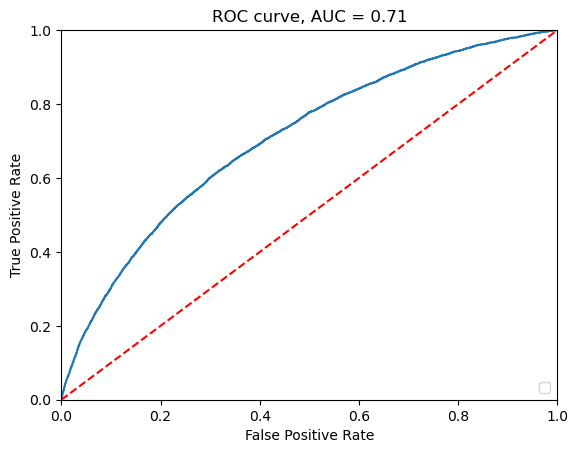

confusion_matrix on test set


array([[70265,   288],
       [ 6170,   154]], dtype=int64)

confusion_matrix on train set


array([[212055,     74],
       [  1815,  16686]], dtype=int64)

confusion_matrix on all data


array([[282320,    362],
       [  7985,  16840]], dtype=int64)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_iter,param_max_leaf_nodes,param_min_samples_leaf,param_scoring,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,1835.777001,449.374697,1.497630,0.608245,0.5,200,None,2,"make_scorer(bank_scoring, greater_is_better=Fa...","{'learning_rate': 0.5, 'max_iter': 200, 'max_l...",-5300.0,-5311.0,-5214.0,-5072.0,-8930.0,-5965.4,1484.763631,1
5,1056.872341,146.831172,1.187334,0.452052,0.75,200,None,2,"make_scorer(bank_scoring, greater_is_better=Fa...","{'learning_rate': 0.75, 'max_iter': 200, 'max_...",-5437.0,-5518.0,-5574.0,-5708.0,-8283.0,-6104.0,1093.072916,2
4,1076.775758,128.613759,1.138287,0.396950,0.75,100,None,2,"make_scorer(bank_scoring, greater_is_better=Fa...","{'learning_rate': 0.75, 'max_iter': 100, 'max_...",-5746.0,-5976.0,-5693.0,-5326.0,-8299.0,-6208.0,1066.086113,3
2,1520.015618,398.895718,1.097448,0.406156,0.5,100,None,2,"make_scorer(bank_scoring, greater_is_better=Fa...","{'learning_rate': 0.5, 'max_iter': 100, 'max_l...",-5394.0,-5244.0,-5117.0,-4999.0,-11045.0,-6359.8,2346.282455,4
7,796.607813,94.451518,1.042595,0.375162,1,200,None,2,"make_scorer(bank_scoring, greater_is_better=Fa...","{'learning_rate': 1, 'max_iter': 200, 'max_lea...",-6649.0,-6359.0,-6339.0,-6022.0,-8478.0,-6769.4,877.050648,5
6,745.207335,52.680805,1.227572,0.626171,1,100,None,2,"make_scorer(bank_scoring, greater_is_better=Fa...","{'learning_rate': 1, 'max_iter': 100, 'max_lea...",-6507.0,-6617.0,-6389.0,-6122.0,-8405.0,-6808.0,815.309512,6
1,8477.800330,3960.786403,3.292143,1.464447,0.1,200,None,2,"make_scorer(bank_scoring, greater_is_better=Fa...","{'learning_rate': 0.1, 'max_iter': 200, 'max_l...",-5198.0,-5300.0,-4968.0,-5111.0,-30393.0,-10194.0,10100.087307,7
0,9918.353014,4913.851163,7.788823,8.744267,0.1,100,None,2,"make_scorer(bank_scoring, greater_is_better=Fa...","{'learning_rate': 0.1, 'max_iter': 100, 'max_l...",-5968.0,-5630.0,-5744.0,-4963.0,-30417.0,-10544.4,9941.940064,8


In [105]:
show_conclusion(gcv2)

In [136]:
# We create the model as a pipeline (originaly it was with the scalering) to save it using mlflow as .pkl
# We add the sample_weight step that is not nativly in pipeline.fit by creating a new class :

from sklearn import pipeline

class PipelineSW(pipeline.Pipeline):
    def fit(self, X, y, sample_weight=None):
        """Fit and pass sample weights only to the last step"""
        if sample_weight is not None:
            kwargs = {self.steps[-1][0] + '__sample_weight': sample_weight}
        else:
            kwargs = {}
        if 'SK_ID_CURR' in X.columns:
            X.drop(columns = ['SK_ID_CURR'], inplace = True)
        return super().fit(X, y, **kwargs)

    def predict(self, X):
        if 'SK_ID_CURR' in X.columns:
            X.drop(columns = ['SK_ID_CURR'], inplace = True)
        return super().predict(X)
    

In [137]:
pipelin = PipelineSW([('classifier' ,
                       HistGradientBoostingClassifier(**gcv2.best_params_)
                      )
                     ]
                    )

In [138]:
pipelin.fit(X_train, y_train, sample_weight = sample_weights)

PipelineSW(steps=[('classifier',
                   HistGradientBoostingClassifier(learning_rate=0.5,
                                                  max_iter=200,
                                                  max_leaf_nodes=None,
                                                  min_samples_leaf=2,
                                                  scoring=make_scorer(bank_scoring, greater_is_better=False)))])

In [139]:
from mlflow.models.signature import infer_signature
import mlflow.sklearn

signature = infer_signature(X_train, y_train)
mlflow.sklearn.save_model(pipelin, 'final_model', signature = signature)


C:\Users\Eric\anaconda3\lib\site-packages\mlflow\models\signature.py:144: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.

C:\Users\Eric\anaconda3\lib\site-packages\mlflow\models\signature.py:145: UserWarning:

Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference tim

In [ ]:
# With our model, for the dashboard, we will need shap values and associated graphs. To do thats, there is an explainer
# dashboard that we can save as .joblib file to use later :

from explainerdashboard import ClassifierExplainer, ExplainerDashboard

explainer = ClassifierExplainer(pipelin['classifier'],
                                data_final.drop(columns = ['SK_ID_CURR', 'TARGET']),
                                data_final['TARGET'],
                                shap = 'tree')
db = ExplainerDashboard(explainer, title="Cool Title", shap_interaction=False)
db.to_yaml("dashboard.yaml", explainerfile="explainer.joblib", dump_explainer=True)

Note: model_output=='probability'. For HistGradientBoostingClassifier shap values normally get calculated against X_background, but paramater X_background=None, so using X instead
Generating self.shap_explainer = shap.TreeExplainer(model, X, model_output='probability', feature_perturbation='interventional')...
Note: Shap interaction values will not be available. If shap values in probability space are not necessary you can pass model_output='logodds' to get shap values in logodds without the need for a background dataset and also working shap interaction values...
Building ExplainerDashboard..
Detected notebook environment, consider setting mode='external', mode='inline' or mode='jupyterlab' to keep the notebook interactive while the dashboard is running...
The explainer object has no decision_trees property. so setting decision_trees=False...
Generating layout...
Calculating shap values...


In [ ]:
# I had issues with python crashing with different explainers building, i debugged the scripts in shap librairies on the VM
# so i finished to run the explainer there.